In [ ]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split

# Load and Prepare Data

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/PSUT/Graduation-Project2/data/KiMoRe_final/KiMoRe_data.csv")
df = df.drop("Unnamed: 0", axis=1)
df["video"] = df["video"].str.replace("/content/drive/MyDrive/", "/content/drive/MyDrive/PSUT/Graduation-Project2/")
df["joint_positions"] = df["joint_positions"].str.replace("/content/drive/MyDrive/", "/content/drive/MyDrive/PSUT/Graduation-Project2/")

In [ ]:
data = []
labels = []

max_video_length = 0

EXERCISE = "Es4"
for index, row in df.iterrows():
    exercise = row['exercise']
    if exercise == EXERCISE:
        video_path = row['video']
        joint_positions_path = row['joint_positions']
        clinical_score = row['clinical_score']

        joint_positions_data = np.loadtxt(joint_positions_path, delimiter=',', skiprows=1)
        video_length = joint_positions_data.shape[0]

        if video_length > max_video_length:
            max_video_length = video_length

        data.append(joint_positions_data)
        labels.append(clinical_score)

for i in range(len(data)):
    data[i] = np.pad(data[i], ((0, max_video_length - data[i].shape[0]), (0, 0)), mode='constant', constant_values=0)

data = np.array(data)
labels = np.array(labels)

print("Data Shape:", data.shape)
print("Labels Shape:", labels.shape)

Data Shape: (78, 1988, 165)
Labels Shape: (78,)


In [ ]:
data = np.nan_to_num(data)
labels = np.nan_to_num(labels)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=0)
print(f"X train: {X_train.shape}, y train: {y_train.shape}")
print(f"X test: {X_test.shape}, y test: {y_test.shape}")

X train: (62, 1988, 165), y train: (62,)
X test: (16, 1988, 165), y test: (16,)


### Testing temporal windows

In [ ]:
N = 4
temporal_windows_data = np.array_split(data, N, axis=1)
temporal_windows_labels = np.array_split(labels, N)

In [ ]:
for window in temporal_windows_data:
  print(window.shape)

(78, 497, 165)
(78, 497, 165)
(78, 497, 165)
(78, 497, 165)


# Build Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import MultiHeadAttention

In [ ]:
class TransformerModel(tf.keras.Model):
    def __init__(self, num_joints, num_windows, window_size, num_heads, d_model, dense_units):
        super(TransformerModel, self).__init__()
        self.num_joints = num_joints
        self.num_windows = num_windows
        self.window_size = window_size
        self.num_heads = num_heads
        self.d_model = d_model

        self.embedding = tf.keras.layers.Dense(d_model, activation='relu')

        self.positional_embedding = tf.keras.layers.Embedding(input_dim=window_size, output_dim=d_model)

        self.transformer_encoder = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)


        self.dense1 = tf.keras.layers.Dense(dense_units, activation='relu')
        self.dense2 = tf.keras.layers.Dense(1)

    def call(self, inputs):
        windows = tf.split(inputs, self.num_windows, axis=1)

        embeddings = []
        for window in windows:
            embedding = self.embedding(window)
            embeddings.append(embedding)

        positional_embeddings = []
        for i in range(self.num_windows):
            positional_embedding = self.positional_embedding(tf.range(self.window_size))
            positional_embeddings.append(positional_embedding)

        embeddings = [embedding + positional_embedding for embedding, positional_embedding in zip(embeddings, positional_embeddings)]

        encoded = [self.transformer_encoder(window_embd, window_embd) for window_embd in embeddings]

        flatten_output = tf.concat(encoded, axis=1)

        dense_output = self.dense1(flatten_output)
        output = self.dense2(dense_output)

        return output

In [ ]:
model = TransformerModel(num_joints=165, num_windows=4, window_size=497, num_heads=4, d_model=128, dense_units=64)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
2/2 [==============================] - 19s 9s/step - loss: 1260.4056 - mae: 32.6133 - val_loss: 938.1146 - val_mae: 28.4429
Epoch 2/100
2/2 [==============================] - 13s 7s/step - loss: 1177.8110 - mae: 31.5048 - val_loss: 845.3973 - val_mae: 26.8028
Epoch 3/100
2/2 [==============================] - 14s 8s/step - loss: 1034.9181 - mae: 29.3947 - val_loss: 696.9190 - val_mae: 23.2842
Epoch 4/100
2/2 [==============================] - 14s 8s/step - loss: 818.2834 - mae: 24.7462 - val_loss: 657.7704 - val_mae: 22.0715
Epoch 5/100
2/2 [==============================] - 14s 7s/step - loss: 765.2758 - mae: 23.2448 - val_loss: 751.1486 - val_mae: 24.6348
Epoch 6/100
2/2 [==============================] - 13s 7s/step - loss: 807.6406 - mae: 24.2066 - val_loss: 640.4249 - val_mae: 21.8891
Epoch 7/100
2/2 [==============================] - 14s 8s/step - loss: 713.6655 - mae: 22.1518 - val_loss: 590.0151 - val_mae: 20.6651
Epoch 8/100
2/2 [==============================] - 1

In [ ]:
model.summary()

Model: "transformer_model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_58 (Dense)            multiple                  21248     
                                                                 
 embedding_20 (Embedding)    multiple                  63616     
                                                                 
 multi_head_attention_14 (M  multiple                  263808    
 ultiHeadAttention)                                              
                                                                 
 dense_59 (Dense)            multiple                  8256      
                                                                 
 dense_60 (Dense)            multiple                  65        
                                                                 
Total params: 356993 (1.36 MB)
Trainable params: 356993 (1.36 MB)
Non-trainable params: 0 (0.00 Byte)
__________

## Model History

In [ ]:
import matplotlib.pyplot as plt

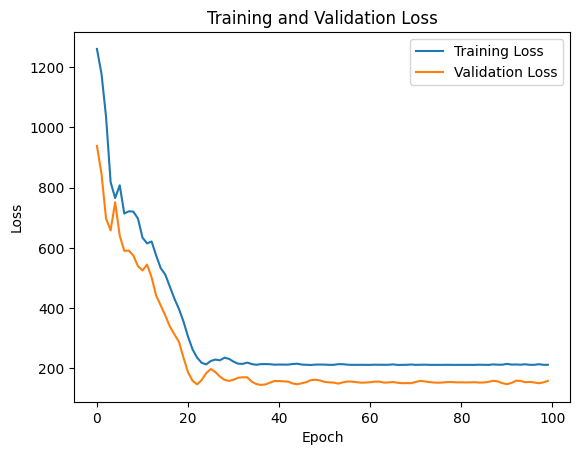

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

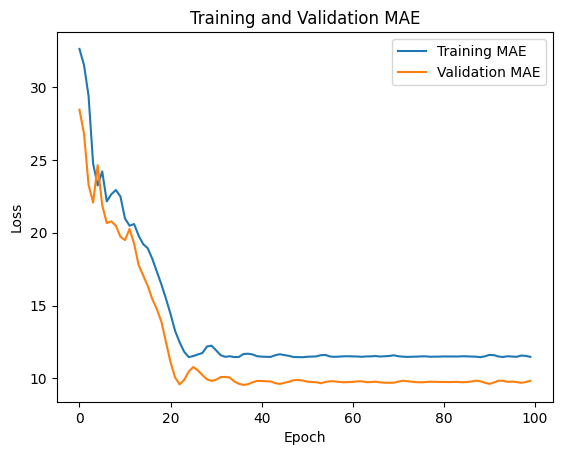

In [ ]:
mae = history.history['mae']
val_mae = history.history['val_mae']

epochs = range(len(loss))
plt.plot(epochs, mae, label='Training MAE')
plt.plot(epochs, val_mae, label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()